In [50]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as skm
import numpy as np
import matplotlib.pyplot as plt

In [51]:
def prepare_dataset(X_dataset, y_dataset, classes, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    df_aux = pd.DataFrame(columns=['id', 'label'])

    list_aux = []

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        sample = {'id':nm_file, 'label':str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')}
        list_aux.append(sample)

    return pd.concat([df_aux, pd.DataFrame(list_aux)], ignore_index=True)


def create_files(X_dataset, y_dataset, classes, dir, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        img = X_dataset[i]
        plt.imsave(dir + nm_file, img)


def create_directory(dir):
    if os.path.exists(dir):
        for file in os.listdir(dir):
            os.remove(dir+file)
    else:
        os.makedirs(dir)

In [52]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [67]:
train_dir = "./train/"
test_dir = "./test/" 

create_directory(train_dir)
create_directory(test_dir)

In [54]:
train_samples = X_train.shape[0]

create_files(X_train, y_train, cifar10_classes, train_dir, train_samples)

train_df = prepare_dataset(X_train, y_train, cifar10_classes, train_samples)

train_df.head()

,id,label
0,0-frog.png,frog
1,1-truck.png,truck
2,2-truck.png,truck
3,3-deer.png,deer
4,4-automobile.png,automobile


In [55]:
test_samples = X_test.shape[0]

create_files(X_test, y_test, cifar10_classes, test_dir, test_samples)

test_df = prepare_dataset(X_test, y_test, cifar10_classes, test_samples)

test_df.head()

,id,label
0,0-cat.png,cat
1,1-ship.png,ship
2,2-ship.png,ship
3,3-airplane.png,airplane
4,4-frog.png,frog


In [56]:
print('Total de imagens para treinamento: %s' % len(os.listdir(train_dir)))
print('Total de imagens para teste      : %s' % len(os.listdir(test_dir)))

Total de imagens para treinamento: 50000
Total de imagens para teste      : 10000


In [57]:
train_datagen=ImageDataGenerator(rescale=1.0/255.0,
                                validation_split=0.25)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

Found 37500 validated image filenames belonging to 10 classes.
Found 12500 validated image filenames belonging to 10 classes.


In [58]:
test_datagen=ImageDataGenerator(rescale=1.0/255.0)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=test_dir,
x_col="id",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(32,32))

Found 10000 validated image filenames belonging to 10 classes.


In [59]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation=('relu')))
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)       

In [60]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
train_step_size = train_generator.n//train_generator.batch_size
validation_step_size = valid_generator.n//valid_generator.batch_size

model.fit_generator(generator=train_generator,
          steps_per_epoch=train_step_size,
          validation_data=valid_generator,
          validation_steps=validation_step_size,
          epochs=15
)

Epoch 1/15
1171/1171 [==============================] - 97s 82ms/step - loss: 1.4958 - accuracy: 0.4758 - val_loss: 1.1973 - val_accuracy: 0.5715
Epoch 2/15
1171/1171 [==============================] - 82s 70ms/step - loss: 1.1030 - accuracy: 0.6096 - val_loss: 1.1558 - val_accuracy: 0.5884
Epoch 3/15
1171/1171 [==============================] - 82s 70ms/step - loss: 0.9795 - accuracy: 0.6547 - val_loss: 0.9956 - val_accuracy: 0.6496
Epoch 4/15
1171/1171 [==============================] - 80s 68ms/step - loss: 0.8990 - accuracy: 0.6844 - val_loss: 1.2277 - val_accuracy: 0.5817
Epoch 5/15
1171/1171 [==============================] - 87s 74ms/step - loss: 0.8337 - accuracy: 0.7060 - val_loss: 0.8781 - val_accuracy: 0.6888
Epoch 6/15
1171/1171 [==============================] - 85s 72ms/step - loss: 0.7694 - accuracy: 0.7269 - val_loss: 0.9956 - val_accuracy: 0.6567
Epoch 7/15
1171/1171 [==============================] - 83s 71ms/step - loss: 0.7164 - accuracy: 0.7483 - val_loss: 0.9464 -

In [62]:
test_generator.reset()

count = 0
y_pred = list()
y_true = list()
class_names = cifar10_classes

for batch in test_generator:
    count+=1

    if count == len(test_generator)+1:
        break
    else:
        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = model.predict(images)

        # Visualização da imagem
        for i in range(len(images)):

            image = images[i]
            label = labels[i]

            prediction = predictions[i]

            # Converte o array de previsão para visualizar a classe e a probabilidade
            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]

            labeled_class = np.argmax(label)
            label = class_names[int(labeled_class)]

            y_true.append(label)

            class_name = class_names[int(predicted_class)]

            y_pred.append(class_name)

1/1 [==============================] - 0s 76ms/step


In [63]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":y_pred})
results.to_csv("results_deep_learning.csv",index=False)

In [64]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.717400  ;  loss = 0.869628 


In [65]:
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

Accuracy:  0.7174
Precision:  0.722520436514952
Recall:  0.7174
F1 Score:  0.7152750081066014


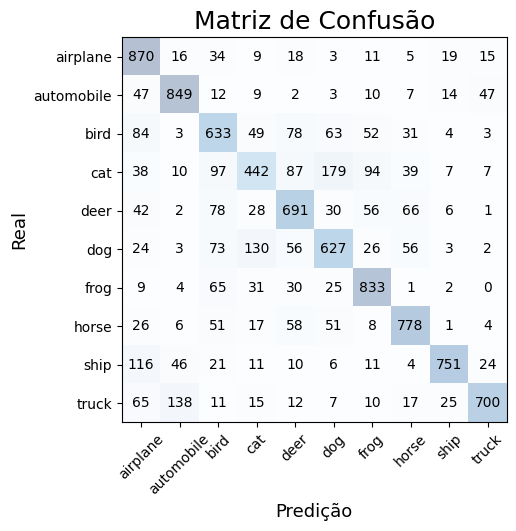

In [66]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cnf_matrix, cmap=plt.cm.Blues, alpha=0.3)
plt.gca().xaxis.tick_bottom()

tick_marks = np.arange(len(cifar10_classes))
plt.xticks(tick_marks, cifar10_classes, rotation=45)
plt.yticks(tick_marks, cifar10_classes)

for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        ax.text(x=j, y=i,s=cnf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predição', fontsize=13)
plt.ylabel('Real', fontsize=13)
plt.title('Matriz de Confusão', fontsize=18)
plt.show()

In [49]:
model_dir = "./trained_models/"
create_directory(model_dir)

# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

model_name = 'trained_model_deep_learning' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (model_dir, model_name))
print("Modelo salvo com o nome: ", model_name)

Modelo salvo com o nome:  trained_model_deep_learning2023-07-02T0155.h5


In [50]:
model_loaded = keras.models.load_model("%s/%s" % (model_dir, model_name))
print("Modelo %s carregado com sucesso" % (model_name))

Modelo trained_model_deep_learning2023-07-02T0155.h5 carregado com sucesso


In [52]:
test_generator.reset()

count = 0
y_pred = list()
y_true = list()
class_names = cifar10_classes

# Loop do data generator de teste que contem as imagens
for batch in test_generator:

    count+=1

    # Condição de saída do loop. Só executaremos o modelo em algumas imagens
    if count == len(test_generator)+1:
        break

    else:
        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = model_loaded.predict(images)

        # Visualização da imagem
        for i in range(len(images)):

            image = images[i]
            label = labels[i]

            prediction = predictions[i]

            # Converte o array de previsão para visualizar a classe e a probabilidade
            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]

            labeled_class = np.argmax(label)
            label = class_names[int(labeled_class)]

            y_true.append(label)

            # Faz o DE-PARA da probabilidade com o tipo de classe da previsão
            # class_name = 'dog' if prediction >= 0.5 else 'cat'

            class_name = class_names[int(predicted_class)]

            y_pred.append(class_name)

            # # Configura a saída das imagens que serão visualizadas
            # plt.figure(figsize=(.5, .5))
            # plt.imshow(image)
            # plt.axis('Off')
            # plt.show()

            # print('%s : %s : %f' % (label, class_name, probability))

1/1 [==============================] - 0s 60ms/step


In [53]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":y_pred})
results.to_csv("results_deep_learning_trained.csv",index=False)